In [1]:

from module.get_naver_news import get_mcp_server_response
from module.get_naver_news import get_news_origin
from module.get_local_pdf import rag_pdf

from langchain_core.tools import tool
from typing import List, Dict, Annotated, TypedDict
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langchain.schema import AIMessage

from langgraph.graph.message import add_messages


USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:

# GraphState 상태 정의
class GraphState(TypedDict):
    question: Annotated[str, "Question"]  # 질문
    context: Annotated[List, "Context"]  # 문서의 검색 결과
    answer: Annotated[str, "Answer"]  # 답변
    messages: Annotated[list, add_messages]  # 메시지(누적되는 list)

In [3]:

# 도구 생성
@tool
async def search_naver_news(query: str) -> List[Dict[str, str]]:
    """Search naver News by input keyword"""
    mcp_response = await get_mcp_server_response(query)
    return {"context": get_news_origin(mcp_response)}

@tool
def search_local_data(query: str) -> List[Dict[str, str]]:
    """Search pdf file infomation by input keyword"""
    news_tool = rag_pdf()
    return {"context": news_tool.search_by_keyword(query)}
    

In [4]:
# 도구 리스트 생성
tools = [search_naver_news, search_local_data]

# ToolNode 초기화
tool_node = ToolNode(tools)

In [5]:
model_with_tools = ChatOpenAI(model="gpt-4o-mini", temperature=0).bind_tools(tools)

In [6]:
model_with_tools

RunnableBinding(bound=ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x7f33fd389610>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x7f33fcdc6d50>, root_client=<openai.OpenAI object at 0x7f33fd351590>, root_async_client=<openai.AsyncOpenAI object at 0x7f33fcdc69d0>, model_name='gpt-4o-mini', temperature=0.0, model_kwargs={}, openai_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'search_naver_news', 'description': 'Search naver News by input keyword', 'parameters': {'properties': {'query': {'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'search_local_data', 'description': 'Search pdf file infomation by input keyword', 'parameters': {'properties': {'query': {'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}]}, config={}, config_factories=[])

In [7]:

# LLM 모델을 사용하여 메시지 처리 및 응답 생성, 도구 호출이 포함된 응답 반환
def call_model(state: GraphState):
    question = state["question"]
    response = model_with_tools.invoke(question)
    return {"messages": [response],"answer":[response]}


# 메시지 상태 기반 워크플로우 그래프 초기화
workflow = StateGraph(GraphState)

# 에이전트와 도구 노드 정의 및 워크플로우 그래프에 추가
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# 워크플로우 시작점에서 에이전트 노드로 연결
workflow.add_edge(START, "agent")

# 에이전트 노드에서 조건부 분기 설정, 도구 노드 또는 종료 지점으로 연결
workflow.add_conditional_edges("agent", tools_condition)

# 도구 노드에서 에이전트 노드로 순환 연결
workflow.add_edge("tools", "agent")

# 에이전트 노드에서 종료 지점으로 연결
workflow.add_edge("agent", END)


from langgraph.checkpoint.memory import MemorySaver

# 메모리 저장소 생성
memory = MemorySaver()

# 그래프 빌더 컴파일
graph = workflow.compile(checkpointer=memory)

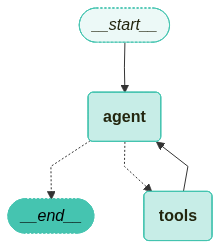

In [8]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

In [ ]:
# 검색 질문 수행

from langchain_core.runnables import RunnableConfig

config = RunnableConfig(
    recursion_limit=5,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정  
)
# result = await graph.ainvoke({"question":"내부 문서중에서 삼성전자 AI 정보"},config)
# print(result)
async for step in graph.astream({"question":"내부 문서중에서 삼성전자 AI 정보"}, config):
    print("Step 상태 변화:\n\n", step)

# result = await graph.ainvoke( {"messages": [("human", "내부 문서중에서 삼성전자 AI 정보")]},config)
# print(result)
# for chunk in graph.astream(
#     {"messages": [("human", "내부 문서중에서 삼성전자 AI 정보")]},
#     stream_mode="values",
# ):
#     chunk["messages"][-1].pretty_print()

Step 상태 변화:

 {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_unFJfD8VdkLEYn4Sh7ouCZeP', 'function': {'arguments': '{"query":"삼성전자 AI"}', 'name': 'search_local_data'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 81, 'total_tokens': 99, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CI7W7CzgycZ9NmLZg3zmqFgMadGgZ', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--921aaa08-b5e8-4c06-ab49-540ee3746117-0', tool_calls=[{'name': 'search_local_data', 'args': {'query': '삼성전자 AI'}, 'id': 'call_unFJfD8VdkLEYn4Sh7ouCZeP', 'type': 'tool_call'}], usage_metadata={'input_tokens': 81, 'output_tokens':

GraphRecursionError: Recursion limit of 5 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [ ]:
outputs =  graph.get_state(config).values


In [ ]:
print(f'Question: {outputs["messages"]}')
print("===" * 20)
print(f'Answer:\n{outputs["answer"]}')

In [ ]:
print(result['messages'][1])

##  메모리 추가

In [ ]:
from langgraph.checkpoint.memory import MemorySaver

# 메모리 저장소 생성
memory = MemorySaver()

# 그래프 빌더 컴파일
graph = workflow.compile(checkpointer=memory)

In [ ]:
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정  
)
inputs = GraphState(question="내부 문서중에서 삼성전자 AI 정보")


In [ ]:
inputs

In [ ]:
result = await graph.ainvoke(inputs,config)
print(result)